# Exp17. cGAN, Pix2Pix, Sketch2Pokemon
## cGAN
- cGAN(Conditional Generative Adversarial Nets : 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소해, 내가 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법. 
- GAN 구조는 생성자 및 판별자라 불리는 두 신경망이 minmax game을 통해 서로 경쟁하며 발전함. 
- GAN과 cGAN의 목적함수를 비교해보면 cGAN에는 G와 D의 입력에 특정 조건을 나타내는 정보인 y를 같이 입력함을 알 수 있음. 
- 생성자가 어떠한 노이즈 z를 입력받았을 때, 특정 조건 y가 함께 입력되기에, y를 통해 z를 어떤 이미지로 만들지 방향을 제어할 수 있음. 
- 생성자 : MNIST나 CIFAR-10 등의 데이터셋의 경우 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣음. 
- 판별자 : 실제 데이터 x와 y(레이블)는 한 쌍을 이뤄야 하고, 생성자에 입력된 y와 판별자에 입력된 y는 동일한 레이블을 나타내야 함. 
- https://velog.io/@nameunzz/cGAN (목적함수 참고)


### (1) Generator 구성하기
#### 데이터 준비하기

In [1]:
!pip list | grep tensorflow-dataset

tensorflow-datasets           4.0.1


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


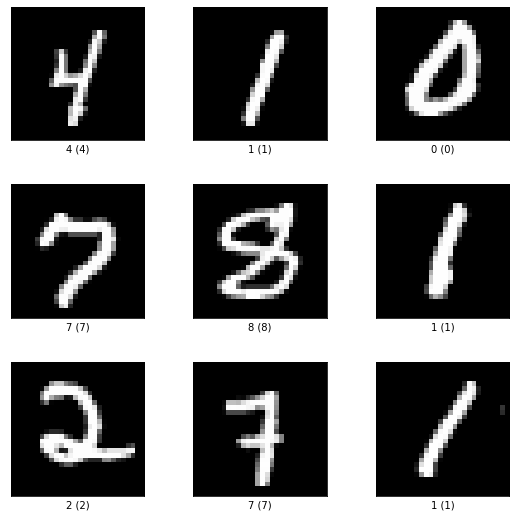

In [2]:
import tensorflow_datasets as tfds

mnist, info = tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

- 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의
- 이미지 픽셀 값을 -1에서 1 사이의 범위로 변경, 레이블 정보를 원-핫 인코딩
- GAN과 cGAN 비교를 위해 label 정보 사용 유무에 따라 두 가지 함수 구성

In [3]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
  image = data["image"]
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

def cgan_preprocessing(data):
  image = data["image"]
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1

  label = tf.one_hot(data["label"], 10)
  return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

Label : tf.Tensor([1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


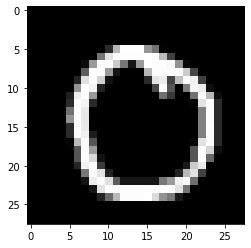

In [4]:
# 한 개의 데이터 확인
import matplotlib.pyplot as plt

for i, j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

#### GAN Generator 구성하기
- 이번 구현은 Tensorflow2의 Subclassing 방법 이용함. 
- Subclassing은 `tensorflow.keras.Model`을 상속받아 클래스를 만들고, 일반적으로 `__init__()` 메서드 안에서 레이어 구성을 정의하고, 구성된 정의를 `call()` 메서드에서 사용해 forward propagation을 진행함. 
- Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사함. 

In [5]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
  def __init__(self):
    super(GeneratorGAN, self).__init__()

    self.dense_1 = layers.Dense(128, activation='relu')
    self.dense_2 = layers.Dense(256, activation='relu')
    self.dense_3 = layers.Dense(512, activation='relu')
    self.dense_4 = layers.Dense(28*28*1, activation='tanh')

    self.reshape = layers.Reshape((28, 28, 1))

  def call(self, noise):
    out = self.dense_1(noise)
    out = self.dense_2(out)
    out = self.dense_3(out)
    out = self.dense_4(out)
    return self.reshape(out)

- `__init__()` 메서드 내에서 사용할 모든 레이어를 정의함. 4개의 fc 레이어 중 하나를 제외하고 모두 ReLU 활성화를 사용함.
- `call()` 메서드에서는 노이즈를 입력받아 `__init__()`에서 정의된 레이어들을 순서대로 통과함. 
- 생성자는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28, 28, 1) 크기로 변환됨.

#### cGAN Generator 구성하기

In [6]:
class GeneratorCGAN(Model):
  def __init__(self):
    super(GeneratorCGAN, self).__init__()

    self.dense_z = layers.Dense(256, activation='relu')
    self.dense_y = layers.Dense(256, activation='relu')
    self.combined_dense = layers.Dense(512, activation='relu')
    self.final_dense = layers.Dense(28*28*1, activation='tanh')
    self.reshape = layers.Reshape((28, 28, 1))

  def call(self, noise, label):
    noise = self.dense_z(noise)
    label = self.dense_y(label)
    out = self.combined_dense(tf.concat([noise, label], axis=-1))
    out = self.final_dense(out)
    return self.reshape(out)

- 노이즈 입력 및 레이블 입력은 각각 1개의 fc 레이어와 ReLU 활성화를 통과함. 
- 각 결과가 서로 연결되어 다시 한 번의 fc 레이어와 ReLU 활성화를 통과함. 
- 1개의 fc 레이어 및 tanh 활성화를 거쳐 28x28 차원의 결과가 생성되고 (28, 28, 1) 크기의 이미지 형태로 변환되어 출력됨.

### (2) Discriminator 구성하기
#### GAN Discriminator 구성하기

In [7]:
class DiscriminatorGAN(Model):
  def __init__(self):
    super(DiscriminatorGAN, self).__init__()
    self.flatten = layers.Flatten()

    self.blocks = []
    for f in [512, 256, 128, 1]:
      self.blocks.append(
          layers.Dense(f, activation=None if f==1 else "relu")
      )

  def call(self, x):
    x = self.flatten(x)
    for block in self.blocks:
      x = block(x)
    return x

- `__init__()`에 `blocks`라는 리스트를 만들고, 반복문을 이용해 필요한 레이어들을 쌓았음. 
- 이러한 방식을 쓰면 각각의 fc 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리함. 
- 판별자의 입력은 생성자가 생성한 (28, 28, 1) 크기의 이미지로, 이를 fc 레이어로 학습하기 위해 `call()`에서는 가장 먼저 `layers.Flatten()`이 적용됨. 
- 마지막 fc 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력됨.

#### cGAN Discriminator 구성하기
- `Maxout`이라는 특별한 레이어가 사용됨.
- `Maxout`은 두 레이어 사이를 연결할 때, 여러 개의 fc 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 함. 


In [8]:
class Maxout(layers.Layer):
  def __init__(self, units, pieces):
    super(Maxout, self).__init__()
    self.dense = layers.Dense(units*pieces, activation='relu')
    self.dropout = layers.Dropout(.5)
    self.reshape = layers.Reshape((-1, pieces, units))

  def call(self, x):
    x = self.dense(x)
    x = self.dropout(x)
    x = self.reshape(x)
    return tf.math.reduce_max(x, axis=2)

- `Maxout` 레이어를 구성할 때 `units`와 `pieces`의 설정이 필요하며, `units` 차원 수를 가진 fc 레이어를 `pieces`개만큼 만들고 그 중 최댓값을 출력함. 
- `units=100`, `pieces=10`으로 설정하면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최댓값을 가져와 최종 1개의 100차원 representation이 출력됨.
- 위에서 정의한 `Maxout` 레이어를 3번만 사용하면 아래와 같이 cGAN의 판별자를 구성할 수 있음.

In [9]:
class DiscriminatorCGAN(Model):
  def __init__(self):
    super(DiscriminatorCGAN, self).__init__()
    self.flatten = layers.Flatten()

    self.image_block = Maxout(240, 5)
    self.label_block = Maxout(50, 5)
    self.combine_block = Maxout(240, 4)

    self.dense = layers.Dense(1, activation=None)

  def call(self, image, label):
    image = self.flatten(image)
    image = self.image_block(image)
    label = self.label_block(label)
    x = layers.Concatenate()([image, label])
    x = self.combine_block(x)
    return self.dense(x)

- GAN의 판별자와 마찬가지로 생성자가 생성한 (28, 28, 1) 크기의 이미지가 입력되므로, 1ayers.Flatten()`이 적용됨. 
- 이미지 입력 및 레이블 입력 각각은 `Maxout` 레이어를 한 번씩 통과한 후 서로 결합되어 `Maxout` 레이어를 한 번 더 통과함.

### (3) 학습 및 테스트하기
- 앞에서 정의한 생성자와 판별자를 이용해 MNIST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해보자. 
- GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의함.
- 진짜 및 가짜를 구별하기 위해 `Binary Cross Entropy`를 사용하고, `Adam optimizer`를 이용해 학습해보자. 

In [10]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
  return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
  return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

#### GAN으로 MNIST 학습하기
- 앞에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용
- 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성

In [11]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
  noise = tf.random.normal([real_images.shape[0], 100])

  with tf.GradientTape(persistent=True) as tape:
    # 생성자를 이용해 가짜 이미지 생성
    fake_images = gan_generator(noise)
    # 판별자를 이용해 진짜 및 가짜 이미지를 각각 판별
    real_out = gan_discriminator(real_images)
    fake_out = gan_discriminator(fake_images)
    # 각 loss 계산
    gene_loss = generator_loss(fake_out)
    disc_loss = discriminator_loss(real_out, fake_out)

  # gradient 계산
  gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
  disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)

  # 모델 학습
  gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
  disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
  
  return gene_loss, disc_loss

- 위 함수를 이용해 우선 10 epoch만큼만 학습을 진행해보자. 
- 100번의 반복마다 각 loss를 출력하도록 함.

In [12]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
  for i, images in enumerate(gan_datasets):
    gene_loss, disc_loss = gan_step(images)

    if (i+1) % 100 == 0:
      print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:2.22174072265625, D:0.12834550440311432
[1/10 EPOCHS, 200 ITER] G:2.5003244876861572, D:0.11745817214250565
[1/10 EPOCHS, 300 ITER] G:2.6706807613372803, D:0.13769254088401794
[1/10 EPOCHS, 400 ITER] G:3.4834423065185547, D:0.12142177671194077
[2/10 EPOCHS, 100 ITER] G:4.325555324554443, D:0.09085878729820251
[2/10 EPOCHS, 200 ITER] G:4.070804595947266, D:0.12045525759458542
[2/10 EPOCHS, 300 ITER] G:3.102034091949463, D:0.24293410778045654
[2/10 EPOCHS, 400 ITER] G:2.839301586151123, D:0.1199600100517273
[3/10 EPOCHS, 100 ITER] G:3.8176636695861816, D:0.1732954978942871
[3/10 EPOCHS, 200 ITER] G:4.165894508361816, D:0.20612101256847382
[3/10 EPOCHS, 300 ITER] G:2.631314754486084, D:0.23327992856502533
[3/10 EPOCHS, 400 ITER] G:3.462052822113037, D:0.10415428876876831
[4/10 EPOCHS, 100 ITER] G:4.2611613273620605, D:0.1323874145746231
[4/10 EPOCHS, 200 ITER] G:2.8261194229125977, D:0.2078149914741516
[4/10 EPOCHS, 300 ITER] G:3.482740879058838, D:0.127476423978

- 짧은 시간 학습된 모델을 테스트해보자. 
- 100차원 노이즈 입력을 10개 사용해 10개의 숫자 손글씨 데이터를 생성해 시각화함. 

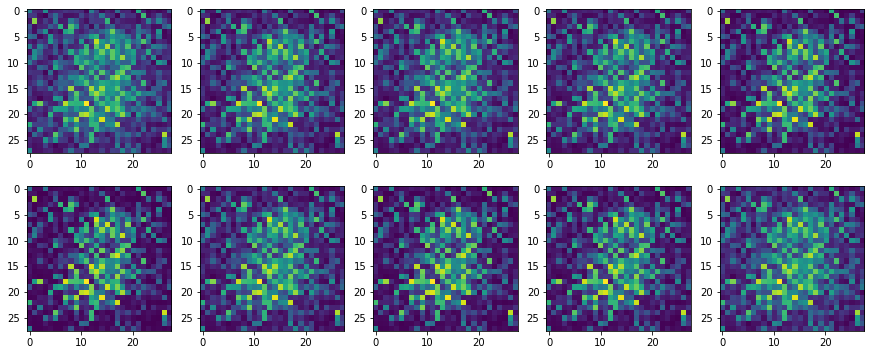

In [13]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15, 6))
for i in range(1, 11):
  plt.subplot(2, 5, i)
  plt.imshow(output[i-1])

- 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없는 것 같음. 
- 위 구현을 그대로 500 epoch 학습한 가중치를 로드해보자.

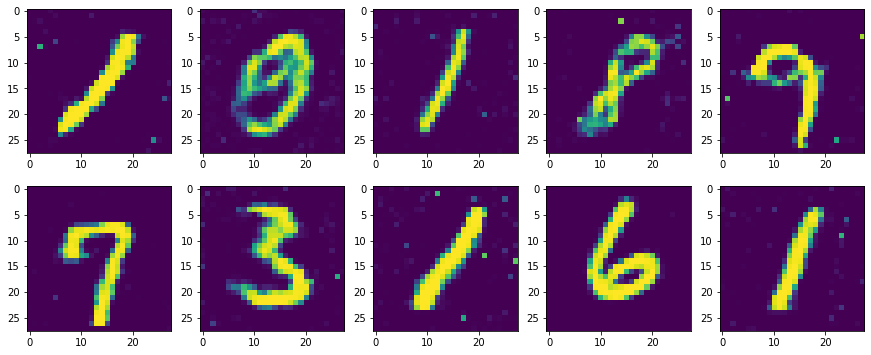

In [14]:
import os
weight_path = '/content/drive/MyDrive/data/GAN_500'

noise = tf.random.normal([10, 100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
  plt.subplot(2, 5, i)
  plt.imshow(output[i-1])

- 위에 보이는 10개의 결과 이미지는 서로 다른 숫자가 시각화된 것일 것이다. (아닐 수도 있음)
- 이런 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수도 있음.
- 내가 원하는 숫자를 바로 얻어내기 위해 아래에서 cGAN을 학습시켜보자.

#### cGAN으로 MNIST 학습하기
- 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습삼아 1 epoch만 학습해보자. 

In [15]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss


EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:6.573404312133789, D:0.0018936325795948505
[1/1 EPOCHS, 199 ITER] G:5.453052520751953, D:0.006178197916597128
[1/1 EPOCHS, 299 ITER] G:3.5795912742614746, D:0.06699802726507187
[1/1 EPOCHS, 399 ITER] G:5.288251876831055, D:0.025851726531982422


- 학습 과정에서 생성자 및 판별자에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없음. 
- 500 epochs 학습한 가중치를 불러오자. 

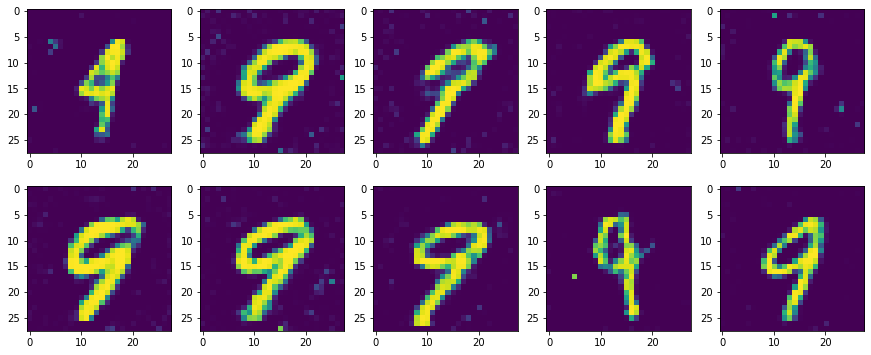

In [16]:
number = 9  # 생성할 숫자 입력

weight_path = '/content/drive/MyDrive/data/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

- `number`에 입력한 숫자에 해당한 손글씨가 시각화됨.
- cGAN을 사용해 조건을 주고 학습하면 특정한 숫자를 만들어내기가 훨씬 쉬워짐.

### GAN의 입력에 이미지 넣기 - Pix2Pix
- 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, 이미지를 입력으로 해 원하는 다른 형태의 이미지로 변환시킬 수 있는 GAN 모델
- Conditional Adversarial Networks로 Image-to-Image Translation을 수행함. 
- 한 이미지의 픽셀에서 다른 이미지의 픽셀로 변환한다는 뜻에서 Pix2Pix라는 이름으로 불린다. 
- 이 구조는 최근 활발하게 연구 및 응용되는 GAN 기반의 Image-to-Image Translation 작업에서 가장 기초가 되는 연구임.
- 노이즈와 레이블 정보를 함께 입력했던 cGAN은 fc 레이어를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 convolution 레이어를 활용한다. 
- GAN 구조를 기반으로 하기 때문에 크게 생성자와 판별자 두 가지 구성 요소로 이루어진다. 

#### Pix2Pix (Generator)
- 생성자는 어떤 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용됨.
- 입력 이미지와 변환된 이미지의 크기는 동일해야 하며, 흔히 사용되는 구조는 Encoder-Decoder 구조임.  

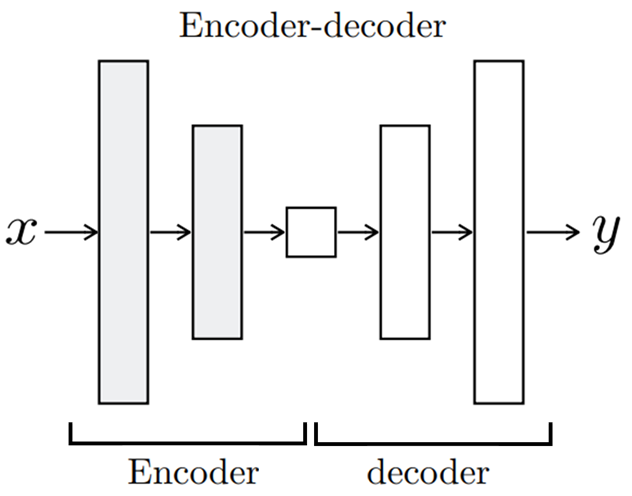

- Encoder에서 입력 이미지를 받으면 단계적으로 이미지를 down-sampling하면서 입력 이미지의 중요한 representation을 학습함. Decoder에서는 이를 이용해 반대로 다시 이미지를 up-sampling하며 입력 이미지와 동일한 크기의 변환된 이미지를 생성함. 
- 이러한 과정은 모두 convolution 레이어로 진행되며, 레이어 내의 수많은 파라미터를 학습해 잘 변환된 이미지를 얻도록 함.
- Encoder의 최종 출력은 `bottleneck`이라고도 불리며, 이 부분은 입력 이미지의 가장 중요한 특징만을 담고 있음.
- 과연 이 중요하지만 작은 특징이 변환된 이미지를 생성하는데 충분할지? -> 이 점을 보완하기 위해 논문에서는 생성자 구조를 하나 더 제안함. (U-Net 구조)  

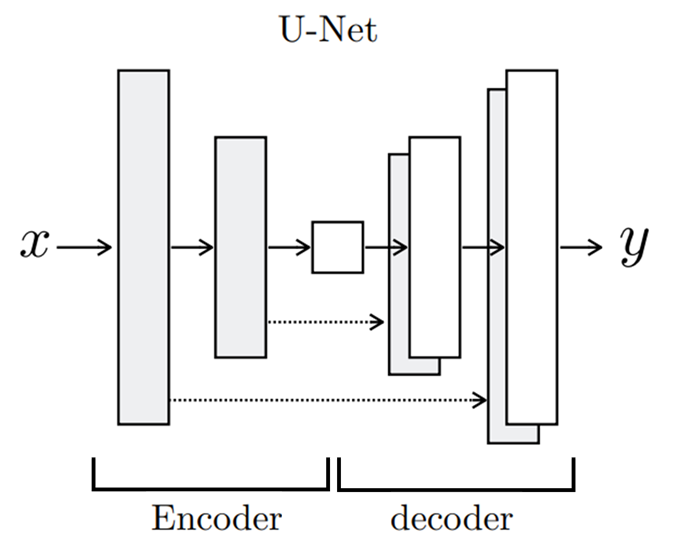

- 각 레이어마다 Encoder와 Decoder가 연결(skip connection)되어 있음.
- Decoder가 변환된 이미지를 더 잘 생성하도록 Encoder로부터 더 많은 추가 정보를 이용하는 방법이며, 단순 Encoder-Decoder 구조의 생성자를 사용한 결과에 비해 비교적 선명한 결과를 얻을 수 있음.


#### Pix2Pix (Loss Function)
- 생성자만을 이용해서 이미지를 변환할 수도 있음. 
- 변환하고자 하는 이미지를 Encoder에 입력해 Decoder의 출력으로 변환된 이미지를 얻을 수 있음. 
- 출력된 이미지와 실제 이미지의 차이로 L2(MSE), L1(MAE) 같은 손실을 계산해 이를 역전파해 네트워크를 학습시키면 됨.
- 그러나 문제는 변화된 이미지의 품질. 이미지를 변환하는데 L1, L2 손실만을 이용해 학습하는 경우 결과가 흐릿해지는 경향이 있다. 생성자가 단순히 이미지의 평균적인 손실만을 줄이고자 파라미터를 학습하기 때문에 이러한 현상이 불가피함.
- 반면 GAN 기반의 학습 방법은 비교적 훨씬 더 세밀한 정보를 잘 표현할 수 있음. 판별자를 잘 속이려면 생성자가 진짜 같은 이미지를 만들어야 하기 때문. 논문에서는 L1 손실과 GAN 손실을 같이 사용하면 더 좋은 결과를 얻을 수 있다고 함. 

#### Pix2Pix (Discriminator)
- 실제 같은 이미지를 얻기 위해서는 GAN의 학습 방법을 이용해야 하며, 생성자를 발전시킬 서포터이자 경쟁자, 판별자가 필요함.
- DCGAN의 판별자는 생성된 가짜 이미지 혹은 진짜 이미지를 하나씩 입력받아 convolution 레이어를 이용해 점점 크기를 줄여나가면서, 최종적으로 하나의 이미지에 대해 하나의 확률 값을 출력했음.
- Pix2Pix는 이 과정에서 의문을 던짐.  
> 하나의 전체 이미지에 대해 하나의 확률 값만을 도출하는 것이 진짜와 가짜를 판별하기에 좋은지?  

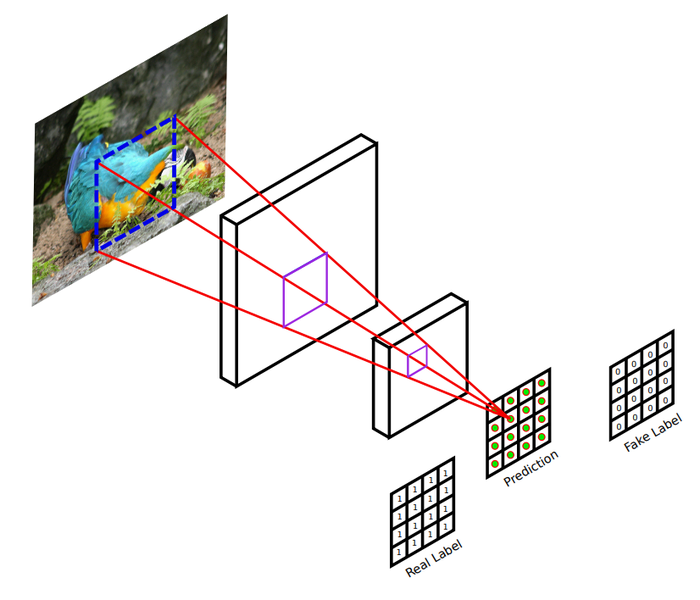

- 위 그림은 Pix2Pix에서 사용되는 판별자를 간략히 나타냄.
- 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률 값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 가짐. (위 그림의 prediction은 16개의 값을 가짐)
- 파란 점선은 여러 출력 중 하나의 출력을 계산하기 위한 입력 이미지의 receptive field 영역을 나타내고 있으며, 전체 영역을 다 보는 것이 아닌 일부 영역에 대해서만 진짜/가짜를 판별하는 하나의 확률 값을 도출.
- 이렇게 서로 다른 영역에 대해 여러 개의 확률 값을 계산 후 이 값을 평균해 최종 판별자의 출력을 생성함. 이 방법은 이미지의 일부 영역(patch)를 이용한다고 해 PatchGAN이라 불림.
- 일반적으로 이미지에서 거리가 먼 두 픽셀은 서로 연관성이 거의 없기 때문에 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 생성자로 하여금 더 진짜 같은 이미지를 만들게 하는 방법임.
- 하지만 너무 작은 patch를 사용하는 경우 품질이 더 나쁜 경우도 있음.

### Sketch2Pokemon (1) 데이터 준비
- 앞서 알아본 pix2pix 모델에 대해 직접 구현하고 실험해보자. 
- Sketch2Pokemon 데이터셋은 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있음.

In [17]:
import os

data_path = '/content/drive/MyDrive/data/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


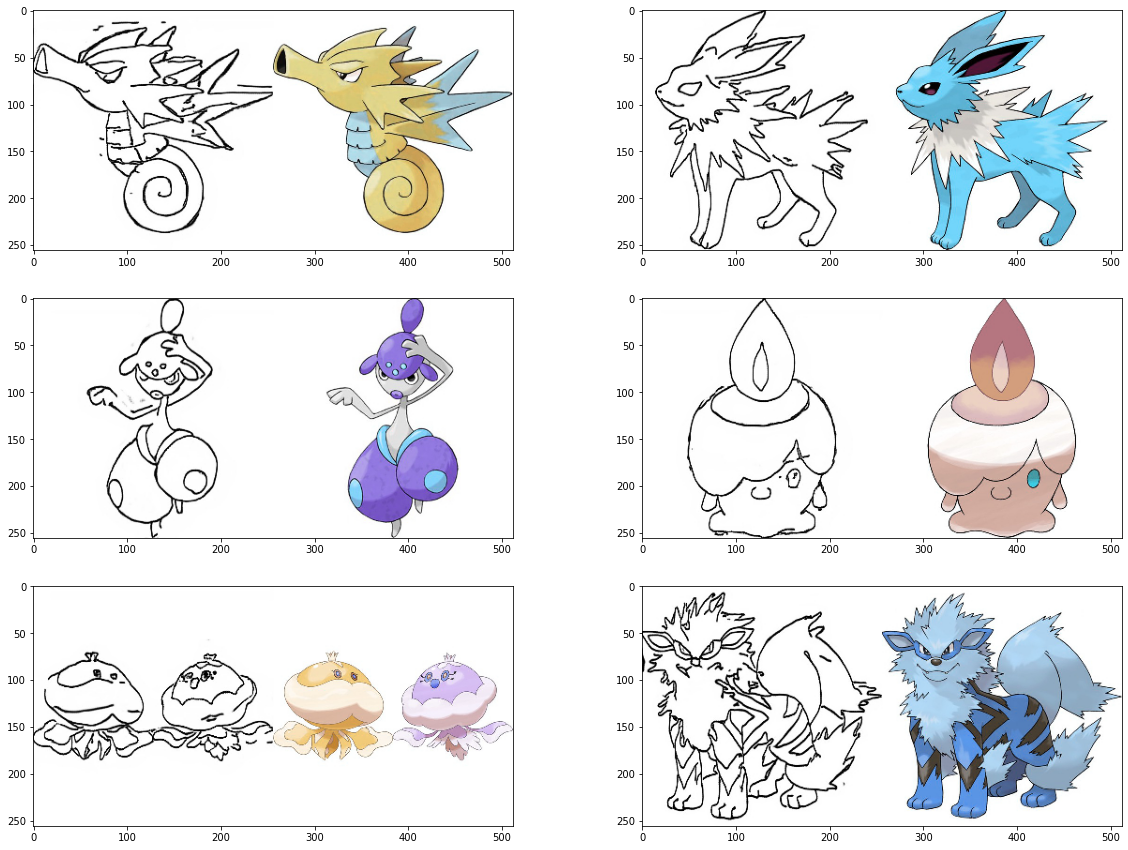

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

- 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음. 
- 일부는 제대로 스케치 되지 않은 이미지도 확인됨. (직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델로 만들었다고 함)

In [19]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


- 이미지의 크기가 (256, 512, 3)이므로 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하자.

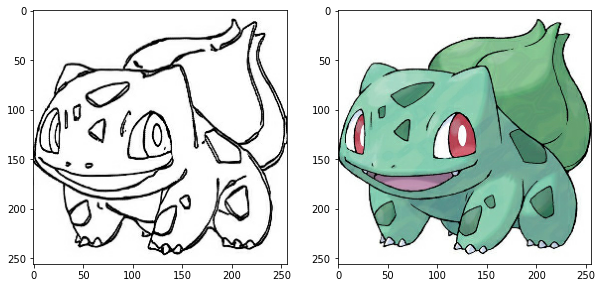

In [20]:
import tensorflow as tf

def normalize(x):
  x = tf.cast(x, tf.float32)
  return (x/127.5) - 1

def denormalize(x):
  x = (x+1) * 127.5
  x = x.numpy()
  return x.astype(np.uint8)

def load_img(img_path):
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, 3)

  w = tf.shape(img)[1] // 2
  sketch = img[:, :w, :] # 꿀팁
  sketch = tf.cast(sketch, tf.float32)
  colored = img[:, w:, :] # 꿀팁
  colored = tf.cast(colored, tf.float32)
  return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

- 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력해 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 목표임. 
- 학습에 사용할 수 있는 데이터의 수는 800개뿐이므로 데이터의 다양성을 높이기 위해 augmentation 수행.

In [21]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function()  # 빠른 텐서플로 연산을 위해 사용
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)  # 두 이미지가 채널 축으로 연결 (두 이미지가 각각 3채널인 경우 6채널이 됨)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:  # 50% 확률
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

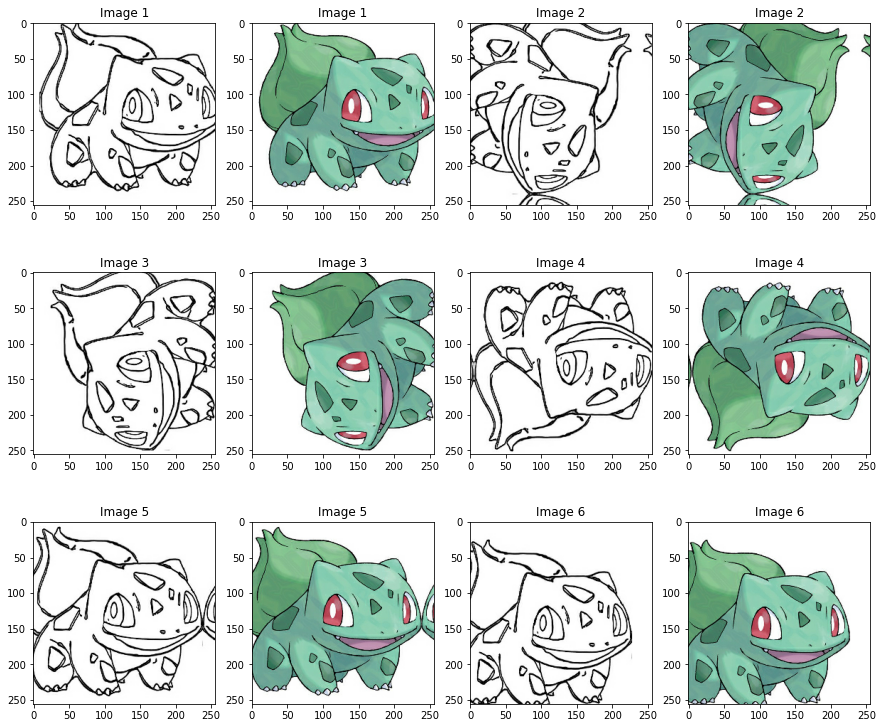

In [22]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
  augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)

  plt.subplot(3,4,i)
  plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
  plt.subplot(3,4,i+1);
  plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
  img_n += 1

- 매우 다양한 이미지가 생성됨. augmentation 방법 외에 더 많은 방법을 활용한다면 좋은 일반화 결과를 기대해 볼 수 있음.
- 위 과정들을 학습 데이터에 적용해, 잘 적용되었는지 하나의 이미지만 시각화해 확인해보자.

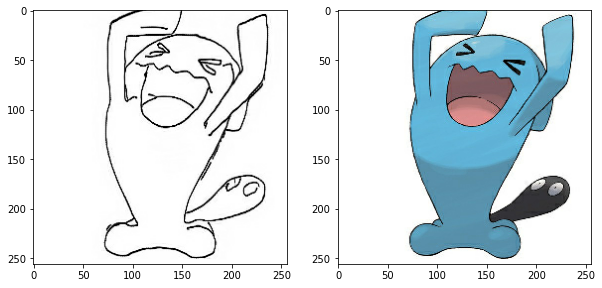

In [23]:
from tensorflow import data

def get_train(img_path):
  sketch, colored = load_img(img_path)
  sketch, colored = apply_augmentation(sketch, colored)
  return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

### Sketch2Pokemon (2) Generator 구성하기
- Pix2Pix 구조 구현에 cGAN 구현과 같이 Tensorflow의 Subclassing 방법을 이용해 모델을 만들자.

#### Generator의 구성요소
- pix2pix 논문에서 표기한 encoder의 "C64"는 어떠한 하이퍼파라미터를 가진 레이어들의 조합을 나타낼까?
- 64개의 4x4 필터에 stride 2를 적용한 Convolution -> 0.2 slope의 LeakyReLU (위 논문의 아래 단락에 BatchNorm을 사용하지 않는다고 쓰여있음)
- decoder의 "CD512"는 어떤 하이퍼파라미터를 가진 레이어들의 조합을 나타낼까?
- 512개의 4x4 필터에 stride 2를 적용한 (Transposed) Convolution -> BatchNorm -> 50% Dropout -> ReLU  
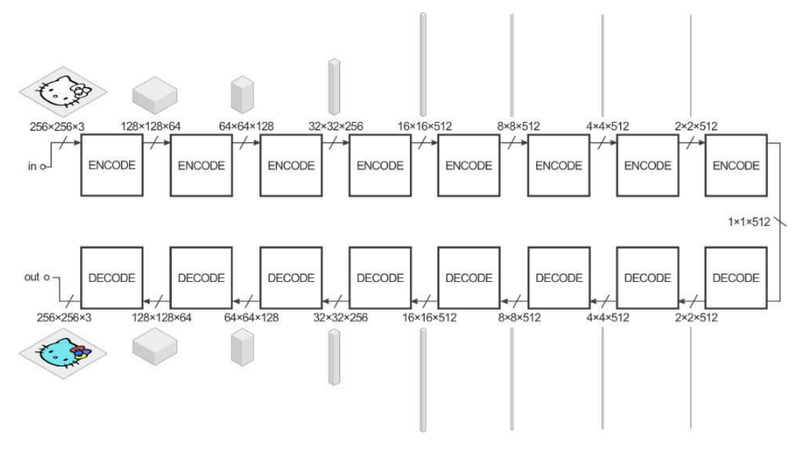

#### Generator 구현하기

In [24]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [25]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [26]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

- 블록을 통과할수록 width, height는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종(1,1,512)로 알맞은 크기가 출력됨을 확인할 수 있음.

In [27]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [28]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

In [29]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
        

EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_1 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_1 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### Sketch2Pokemon (3) Generator 재구성하기
- 더 좋은 결과를 기대하기 위해 U-Net 구조를 만들고 실험해보자. 

In [30]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [31]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]  # Encoder의 마지막 출력은 Decoder로 직접 입력되기에 skip connectiond의 대상이 아님
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):  # encoder-decoder 간의 skip connection이 대칭이기에 역순으로 decoder에 연결
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

- Encoder와 Decoder 사이의 skip connection을 위해 `features`라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담음.
- 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한 번 각각의 Decoder 블록들을 통과하는데, `features`  리스트에 있는 각각의 출력들이 Decoder 블록의 입력으로 사용됨.

In [32]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_16 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_17 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_16[0][0]']        
                                                                                            

### Sketch2Pokemon (4) Discriminator 구성하기


In [33]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [34]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_24 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_45 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [35]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [36]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_7 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_7 (Concatenate)    (None, 256, 256, 6)  0           ['input_6[0][0]',                
                                                                  'input_7[0][0]']          

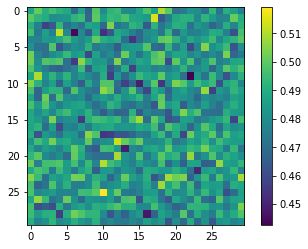

In [37]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

### Sketch2Pokemon (5) 학습 및 테스트하기

In [38]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

- Generator 손실 함수(`get_gene_loss`)는 총 3개의 입력이 있음. 
- `fake_disc`는 Generator가 생성한 가짜 이미지를 Discriminator에 입력해 얻어진 값. 
- 실제 이미지를 뜻하는 1과 비교하기 위해 `tf.ones_like()`를 사용함. 
- 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지와 실제 이미지 사이의 MAE를 계산함.
- Discriminator의 손실 함수('get_disc_loss`)는 2개의 입력이 있으며, 가짜 이미지와 진짜 이미지가 각각 입력되어 얻어진 값.
- Discriminator는 실제 이미지를 잘 구분해내야 하므로, `real_disc`는 1로 채워진 벡터와, `fake_disc`는 0으로 채워진 벡터와 비교함. 

In [39]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [40]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [41]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0056                     
L1_loss:0.5553                     
Discriminator_loss:1.1214

EPOCH[1] - STEP[20]                     
Generator_loss:1.0740                     
L1_loss:0.2941                     
Discriminator_loss:1.1532

EPOCH[1] - STEP[30]                     
Generator_loss:0.9778                     
L1_loss:0.2440                     
Discriminator_loss:1.1458

EPOCH[1] - STEP[40]                     
Generator_loss:0.7800                     
L1_loss:0.2749                     
Discriminator_loss:1.1069

EPOCH[1] - STEP[50]                     
Generator_loss:1.1660                     
L1_loss:0.2041                     
Discriminator_loss:0.8616

EPOCH[1] - STEP[60]                     
Generator_loss:0.9450                     
L1_loss:0.2443                     
Discriminator_loss:0.7958

EPOCH[1] - STEP[70]                     
Generator_loss:2.0926                     
L1_loss:0.3612                    

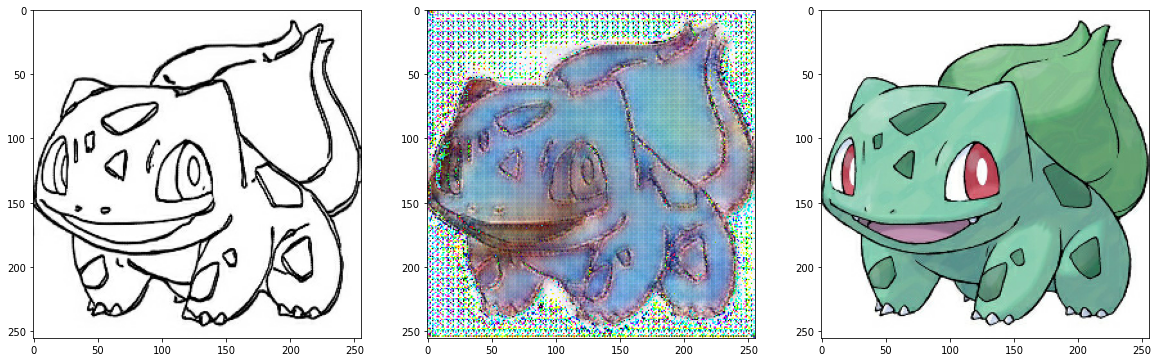

In [42]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))